In [81]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import tempfile

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset, random_split

In [82]:
from load_data import *
from model_mae_timm import *

In [83]:
def setup_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [84]:
setup_seed()

In [85]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 512
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10
DATA_DIR = './data'

# Optimizer parameters
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# Pretraining parameters
EPOCHS = 100

# Augmentation parameters
IMAGE_SIZE = 32
PATCH_SIZE = 2
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75

# Encoder and Decoder parameters
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = 2
ENC_TRANSFORMER_UNITS = [ENC_PROJECTION_DIM * 2, ENC_PROJECTION_DIM]
DEC_TRANSFORMER_UNITS = [DEC_PROJECTION_DIM * 2, DEC_PROJECTION_DIM]

In [86]:
dataloader, train_set, test_set = prepare_data_cifar(DATA_DIR, INPUT_SHAPE, IMAGE_SIZE, BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


In [87]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MAE_ViT().to(device)

In [88]:
optim = torch.optim.AdamW(model.parameters(), 
                          lr=LEARNING_RATE * BATCH_SIZE / 256, 
                          betas=(0.9, 0.95), 
                          weight_decay=WEIGHT_DECAY)

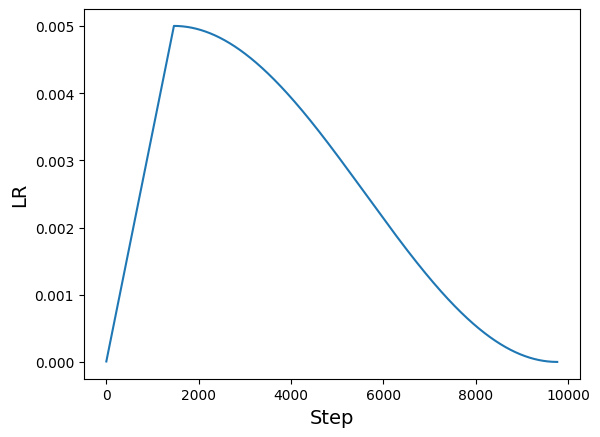

In [89]:
from torch.optim.lr_scheduler import LRScheduler

class WarmUpCosine(LRScheduler):
    def __init__(self, optimizer: optim, total_steps: int, warmup_steps: int, learning_rate_base: float, warmup_learning_rate: float, last_epoch: int = -1):
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = np.pi
        super(WarmUpCosine, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1  

        if step > self.total_steps:
            return [0.0 for _ in self.base_lrs]

        cos_annealed_lr = 0.5 * self.learning_rate_base * (1 + np.cos(self.pi * (step - self.warmup_steps) / (self.total_steps - self.warmup_steps)))

        if step < self.warmup_steps:
            slope = (self.learning_rate_base - self.warmup_learning_rate) / self.warmup_steps
            warmup_rate = slope * step + self.warmup_learning_rate
            return [warmup_rate for _ in self.base_lrs]
        else:
            return [cos_annealed_lr for _ in self.base_lrs]

total_steps = int((len(train_set) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)

scheduler = WarmUpCosine(optim, total_steps=total_steps, warmup_steps=warmup_steps, learning_rate_base=LEARNING_RATE, warmup_learning_rate=0.0)

# Plot the learning rate schedule
lrs = []
for step in range(total_steps):
    scheduler.step()
    lrs.append(optim.param_groups[0]['lr'])

plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%

img shape torch.Size([512, 3, 32, 32])
patches shape torch.Size([512, 192, 16, 16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


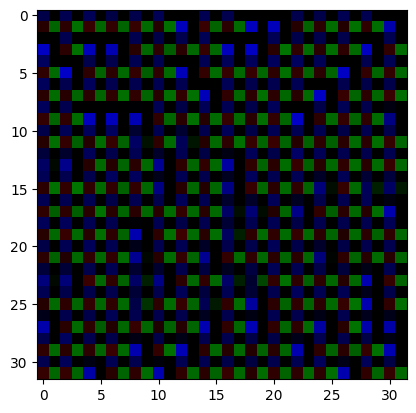

  0%|          | 0/98 [00:33<?, ?it/s]


KeyboardInterrupt: 

In [90]:
model_path = './model/mae_vit.pt'
step_count = 0
optim.zero_grad()
for e in range(EPOCHS):
    model.train()
    losses = []
    for img, label in tqdm(iter(dataloader)):
        step_count += 1
        img = img.to(device)
        predicted_img, mask = model(img)
        # show the predicted image[0]
        plt.imshow(predicted_img[0].permute(1, 2, 0).detach().cpu().numpy())
        plt.show()
        
        
        loss = torch.mean((predicted_img - img) ** 2 * mask) / MASK_PROPORTION
        loss.backward()
        if step_count % 1 == 0:
            optim.step()
            optim.zero_grad()
        losses.append(loss.item())
    scheduler.step()
    avg_loss = sum(losses) / len(losses)
    # writer.add_scalar('mae_loss', avg_loss, global_step=e)
    print(f'In epoch {e}, average traning loss is {avg_loss}.')

    ''' visualize the first 16 predicted images on val dataset'''
    model.eval()
    with torch.no_grad():
        val_img = torch.stack([test_set[i][0] for i in range(16)])
        val_img = val_img.to(device)
        predicted_val_img, mask = model(val_img)
        predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
        img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
        img = rearrange(img, '(v h1 w1) c h w -> c (h1 h) (w1 v w)', w1=2, v=3)
        # writer.add_image('mae_image', (img + 1) / 2, global_step=e)
    
    ''' save model '''
    torch.save(model, model_path)